In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy as sp
import os
import datetime
import xgboost as xgb
import warnings
%matplotlib inline

In [166]:
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')


In [167]:
#drop training rows where full_sq is missing
train = train[~train['full_sq'].isnull()]

In [168]:
#clean up dates in training data
train['year'] = train['timestamp'].map(lambda x: int(x.split('-')[0]))
train['month'] = train['timestamp'].map(lambda x: int(x.split('-')[1]))
train['day'] = train['timestamp'].map(lambda x: int(x.split('-')[2]))

train['date'] = train.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)

In [169]:
#clean up dates in test data
test['year'] = test['timestamp'].map(lambda x: int(x.split('-')[0]))
test['month'] = test['timestamp'].map(lambda x: int(x.split('-')[1]))
test['day'] = test['timestamp'].map(lambda x: int(x.split('-')[2]))

test['date'] = test.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)

In [170]:
#impute 5 missing full_sq in test data
test.loc[test['id'] == 30938, 'full_sq'] = 37.80
test.loc[test['id'] == 35857, 'full_sq'] = 42.07
test.loc[test['id'] == 34670, 'full_sq'] = 122.60

#np.nanmedian(test.full_sq)

test.loc[test['id'] == 36824, 'full_sq'] = 50.42
test.loc[test['id'] == 35108, 'full_sq'] = 50.42

In [171]:
## log transformation
train.loc[:, 'log_price_doc'] = np.log(train['price_doc'] + 1)


In [172]:
#impute test product_type as investment

test.loc[test['product_type'].isnull(),'product_type'] = "Investment"

In [173]:
## label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = dict()

for feature in ['product_type', 'sub_area']:
    print('encoding feature: {}'.format(feature))
    label_encoder[feature] = LabelEncoder()
    label_encoder[feature].fit(train[feature])
    train.loc[:, feature + '_le'] = label_encoder[feature].transform(train[feature])
    test.loc[:, feature + '_le'] = label_encoder[feature].transform(test[feature])

encoding feature: product_type
encoding feature: sub_area


In [208]:
#make test and train sets
# Convert to numpy values
model_features = ['full_sq', 'floor', 'month', 'cpi', 'usdrub_3m_vol',
                  'material', 'build_year', 'num_room', 'usdrub',
                  'state', 'product_type_le', 'sub_area_le']

X_train = train_macro[model_features].values
Y_train = train_macro['log_price_doc'].values
X_test = test_macro[model_features].values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(30428, 12)
(30428,)
(7662, 12)


In [209]:
from sklearn.cross_validation import train_test_split

X_train_sub, X_val, Y_train_sub, Y_val = train_test_split(X_train, Y_train, random_state=1, train_size=0.7)

In [129]:
#size_ = 7000
#X_train_sub, Y_train_sub = X_train[:-size_],  Y_train[:-size_]
#X_val, Y_val = X_train[-size_:],  Y_train[-size_:]

In [210]:
dtrain = xgb.DMatrix(X_train, 
                    Y_train, 
                    feature_names=model_features)
dtrain_sub = xgb.DMatrix(X_train_sub, 
                        Y_train_sub, 
                        feature_names=model_features)
d_val = xgb.DMatrix(X_val, 
                    Y_val, 
                    feature_names=model_features)
dtest = xgb.DMatrix(X_test, 
                    feature_names=model_features)

In [213]:
# hyperparameters
xgb_params = {
    'eta': 0.05,
    'gamma': 0,
    'alpha': 1,
    'max_depth': 6,
    'subsample': .8,
    'colsample_bytree': 0.75,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [214]:
sub_model = xgb.train(xgb_params, 
                      dtrain_sub, 
                      num_boost_round=6000,
                      evals=[(d_val, 'val')],
                      early_stopping_rounds=50, 
                      verbose_eval=50)

[0]	val-rmse:14.3636
Will train until val-rmse hasn't improved in 50 rounds.
[50]	val-rmse:1.21227
[100]	val-rmse:0.49779
[150]	val-rmse:0.485616
[200]	val-rmse:0.482629
[250]	val-rmse:0.481888
[300]	val-rmse:0.481287
Stopping. Best iteration:
[299]	val-rmse:0.481232



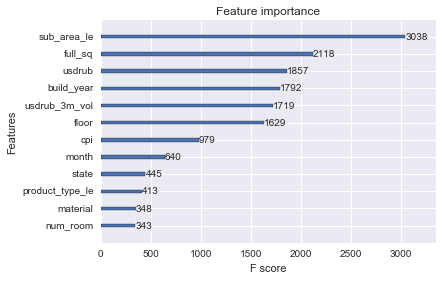

In [215]:
xgb.plot_importance(sub_model)

In [216]:
full_model = xgb.train(xgb_params,
                       dtrain, 
                       num_boost_round=sub_model.best_iteration,
                       verbose_eval=20)

In [217]:
log_y_pred = full_model.predict(dtest)
y_pred = np.exp(log_y_pred) - 1

In [218]:
submit = pd.DataFrame({'id': np.array(test.index), 'price_doc': y_pred})
submit.to_csv('submission.csv', index=False)

# Code to Read in Macro Data

In [148]:
macro_test = pd.read_csv('macro_test.csv')
macro_train = pd.read_csv('macro_train.csv')

In [144]:
macro_test.head()

,cpi,usdrub,micex,mortgage_rate,date,usdrub_3m_vol,usdrub_1m_vol
0,490.5,55.5989,1639.70,13.29,2015-07-01,2.155952,0.901930
1,490.5,55.4093,1641.05,13.29,2015-07-02,2.133872,0.822948
2,490.5,55.9695,1631.65,13.29,2015-07-03,2.120414,0.837574
3,490.5,55.9695,1631.65,13.29,2015-07-04,2.106840,0.837046
4,490.5,55.9695,1631.65,13.29,2015-07-05,2.118570,0.829804


In [149]:
macro_train.head()

,cpi,usdrub,micex,mortgage_rate,date,price_doc,usdrub_3m_vol,usdrub_1m_vol
0,354.0,29.0048,1438.74,11.84,2011-08-20,NaN,0.475248,0.730178
1,354.0,29.0048,1438.74,11.84,2011-08-21,NaN,0.482400,0.728679
2,354.0,29.1005,1443.93,11.84,2011-08-22,NaN,0.492191,0.727382
3,354.0,28.9525,1444.11,11.84,2011-08-23,NaN,0.498799,0.719693
4,354.0,28.9506,1461.62,11.84,2011-08-24,NaN,0.505481,0.707092


In [201]:
#clean up dates in training data
macro_train['year'] = macro_train['date'].map(lambda x: int(x.split('-')[0]))
macro_train['month'] = macro_train['date'].map(lambda x: int(x.split('-')[1]))
macro_train['day'] = macro_train['date'].map(lambda x: int(x.split('-')[2]))

macro_train['date'] = macro_train.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)

In [202]:
#clean up dates in training data
macro_test['year'] = macro_test['date'].map(lambda x: int(x.split('-')[0]))
macro_test['month'] = macro_test['date'].map(lambda x: int(x.split('-')[1]))
macro_test['day'] = macro_test['date'].map(lambda x: int(x.split('-')[2]))

macro_test['date'] = macro_test.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)

In [194]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,young_female,young_male,zd_vokzaly_avto_km,year,month,day,date,log_price_doc,product_type_le,sub_area_le
0,1,2011-08-20,43.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,10147,11007,14.231961,2011,8,20,2011-08-20,15.581952,0,9
1,2,2011-08-23,34.0,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,7802,7925,9.242586,2011,8,23,2011-08-23,15.607270,0,70
2,3,2011-08-27,43.0,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,6193,6835,9.540544,2011,8,27,2011-08-27,15.555977,0,129
3,4,2011-09-01,89.0,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,13883,14680,17.478380,2011,9,1,2011-09-01,16.388123,0,65
4,5,2011-09-05,77.0,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,6209,7159,1.595898,2011,9,5,2011-09-05,16.608603,0,6


In [203]:
train_macro = pd.merge(left=train, 
         right=macro_train[['cpi', 'usdrub', 'usdrub_3m_vol', 'date']], 
         how="left", on="date")

In [206]:
test_macro = pd.merge(left=test, 
         right=macro_test[['cpi', 'usdrub', 'usdrub_3m_vol', 'date']], 
         how="left", on="date")

In [207]:
test_macro.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,zd_vokzaly_avto_km,year,month,day,date,product_type_le,sub_area_le,cpi,usdrub,usdrub_3m_vol
0,30474,2015-07-01,39.0,20.7,2,9.0,1.0,1998.0,1.0,8.9,...,27.553486,2015,7,1,2015-07-01,0,38,490.5,55.5989,2.155952
1,30475,2015-07-01,79.2,NaN,8,17.0,1.0,NaN,3.0,1.0,...,27.421853,2015,7,1,2015-07-01,1,103,490.5,55.5989,2.155952
2,30476,2015-07-01,40.5,25.1,3,5.0,2.0,1960.0,2.0,4.8,...,10.093318,2015,7,1,2015-07-01,0,84,490.5,55.5989,2.155952
3,30477,2015-07-01,62.8,36.0,17,17.0,1.0,2016.0,2.0,62.8,...,37.436772,2015,7,1,2015-07-01,1,105,490.5,55.5989,2.155952
4,30478,2015-07-01,40.0,40.0,17,17.0,1.0,NaN,1.0,1.0,...,25.699461,2015,7,1,2015-07-01,1,103,490.5,55.5989,2.155952


In [193]:
train_macro[model_features]['cpi'].isnull().sum()

30428